# Scientific Notebook: Model Fairness Evaluation

## Purpose
This notebook is designed to evaluate the fairness of predictive models or different crime prediction scenarios. It focuses on calculating and analyzing various fairness metrics (such as Gini, Variance, MaxMin, etc.) to understand how predictions distribute resources or attention across different areas, assessing potential disparities.

## Workflow Stage
This notebook is in the **Model Evaluation and Fairness Analysis** stage of the data science workflow. It takes model outputs (predictions) and potentially real data/geographic configurations to compute and analyze fairness indicators.

## About
This notebook processes prediction results or scenario outputs to quantify and compare their fairness using established metrics. The goal is to provide insights into the equity implications of different models or strategies.


### 1. Environment Setup and Path Configuration

This block sets up the environment by importing necessary libraries, mounting Google Drive (specifically for Colab), and adding directories containing custom scripts and libraries to the system path. This is required to access project resources and helper functions used throughout the notebook.

In [ ]:
# Import necessary libraries
from google.colab import drive
import geopandas as gpd # Library for working with geospatial data

# Mount Google Drive to access files. This is specific to Google Colab.
# For other environments, alternative methods are needed to access data/libraries.
drive.mount('/content/drive')

# Import system and path libraries
import sys, os.path, os

# Define paths to directories containing custom libraries and scripts
# NOTE: These paths are specific to the Google Drive structure and need adaptation for other environments.
path_opencp="drive/.../Librerias/PredictCode/"
path_fairness="drive/.../Librerias/"
path_exp="drive/.../EXP0/SCRIPTS/"

# Add these directories to the Python system path
# This makes modules/scripts within these folders importable.
sys.path.insert(0, os.path.abspath(path_opencp))
sys.path.insert(0, os.path.abspath(path_fairness))
sys.path.insert(0, os.path.abspath(path_exp))

Mounted at /content/drive


### 2. Library Imports and Working Directory Setup

This block imports the Python libraries required for data processing, analysis, and visualization. It also changes the current working directory to a specific project folder (`EXP0`) on Google Drive. This setup is necessary to access project-specific data files and simplify subsequent file operations within the notebook.

In [ ]:
import pickle as pkl
import os
import datetime
from datetime import timedelta
import numpy as np
import open_cp
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import numpy as np
from matplotlib.ticker import PercentFormatter

# Change the current working directory to the specific experiment folder
# This is done to simplify relative paths for accessing files within this directory.
# NOTE: This path is specific to the Google Drive structure and needs adaptation for other environments.
os.chdir("drive/.../EXP0/")

### 3. Utility Function, Fairness Module Import, and Grid Dimensions

This block defines a helper function `plot_intensity` for visualizing 2D intensity data using a colormap. It then imports specific modules (`utils`, `measures`) from a custom `fairness_measures` library, which likely contains definitions for fairness calculations or related utilities. Finally, it sets the values for `filas` (rows) and `columnas` (columns), which appear to define the dimensions of a grid used in the analysis.

In [ ]:
# Define a function to plot 2D intensity data
def plot_intensity(intensity):
    # Create a figure and axes for the plot with a specified size
    fig, ax = plt.subplots(figsize=(11,5))
    # Display the intensity data as an image using the 'jet' colormap
    # interpolation='none' shows pixel edges, alpha sets transparency, vmin sets minimum color value
    im=ax.imshow(intensity, 'jet', interpolation='none', alpha=0.7,vmin=0)
    # Invert the y-axis to have the origin at the top-left, common in matrix representations
    ax.invert_yaxis()
    # Add a colorbar to the plot to show the mapping of colors to intensity values
    plt.colorbar(im)
    # Display the plot
    plt.show(ax)


# Import specific modules from a custom fairness measures library
# 'utils' likely contains utility functions or definitions
# 'measures' likely contains the definitions of the fairness metrics used
from fairness_measures import utils, measures ## libreria con definicion de variables protegidas y medidas

# Define variables for grid dimensions
# These specify the number of rows and columns for a grid, likely used for spatial discretization
filas=5
columnas=5

### 4. Define and Visualize Spatial Mask, Load Global Parameters, and Set Analysis Region

This block initializes a boolean NumPy array named `mask`, which visually represents a specific area (likely a protected zone or a region of interest) within a grid. It then uses the previously defined `plot_intensity` function to visualize this mask. The code proceeds to process this mask using a utility function from the `fairness_measures.utils` module and imports global configuration parameters (`x_min`, `x_max`, `y_min`, `y_max`, etc.) from a `global_vars` module. Finally, it defines the overall rectangular geographic `region` for the analysis based on the imported boundaries.

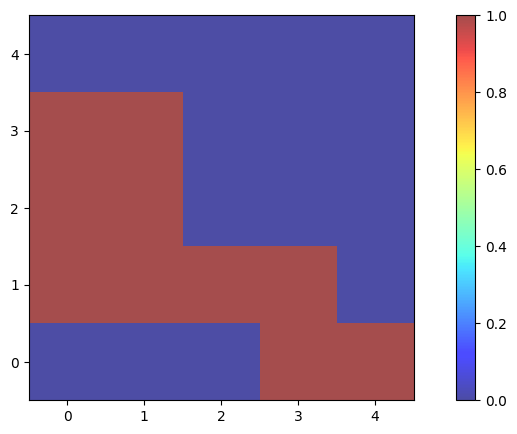

In [ ]:
# Define a boolean mask array
# This array represents a specific spatial area or region of interest (e.g., a protected zone)
# The True values indicate the area covered by the mask.
mask=np.array([[False,False,False,True,True],
               [True,True,True,True,False],
               [True,True,False,False,False],
               [True,True,False,False,False],
               [False,False,False,False,False],
               ])

# Visualize the defined mask using the helper function
plot_intensity(mask)

# Process the mask using a utility function from the fairness measures library
# This likely prepares the mask data for subsequent calculations.
# The input is a dictionary mapping a key ("p") to the mask array.
total_mask=utils.generate_total_masks({"p":mask})

# Import global configuration parameters for the analysis region and grid
# These variables define the spatial extent and resolution of the analysis area.
from global_vars import x_min,x_max,y_min,y_max,grid_size,days_time_unit

# Define the rectangular analysis region using the imported global boundaries
region = open_cp.RectangularRegion(x_min,x_max, y_min,y_max)

### 5. Define Intensity Processing and Earth Mover's Distance Functions

This block defines three core functions used in the evaluation:
1.  `intensity_m`: Converts a model's raw prediction for a given date into a normalized spatial intensity matrix over the defined grid. It includes error handling for different model prediction outputs.
2.  `get_real_m`: Processes real event data (`timedpoints`) for a specific date, aggregating it into a normalized spatial intensity matrix over the grid.
3.  `EMD`: Implements a manual calculation of the Earth Mover's Distance (EMD) between two normalized intensity matrices (`m1`, `m2`) based on the grid size. It utilizes linear programming to find the optimal "flow" between the two distributions.
Additionally, it imports the standard `scipy` implementation of the Wasserstein distance (aliased as `emd`), which is equivalent to EMD. These functions are fundamental for comparing predicted spatial distributions against real event distributions using the EMD metric.

In [ ]:
# Define a function to convert a model prediction into a normalized intensity matrix
# Takes a model object and a date as input.
def intensity_m(model,date,region=region,grid_size=grid_size):
    # Attempt to get prediction for the specified date (some models might require it)
    try:
        predict=model.predict(date)
    # If predicting with a date fails (model might not support dated prediction), predict without date
    except:
        predict=model.predict()

    # Attempt to convert the continuous prediction object to a GridPredictionArray
    # This is common for models that output continuous spatial functions.
    try:
        M=open_cp.predictors.GridPredictionArray.from_continuous_prediction_region(predict, region, grid_size, grid_size)
        # Extract the intensity matrix from the grid array
        intensity_matrix= M.intensity_matrix
    # If the prediction is already a grid-based object, extract the matrix directly
    except:
        intensity_matrix = predict.intensity_matrix

    # Normalize the intensity matrix so its sum is 1
    return intensity_matrix/intensity_matrix.sum()

### Real data processing function
# Import a specific module from open_cp for simple prediction methods (like counting)
import open_cp.naive as naive
# Define a function to get the normalized intensity matrix of real events for a given day
# Takes timed event data, a prediction date, grid size, and region as input.
def get_real_m(timedpoints,p_date,grid_size=grid_size,region=region):
    # Filter real events to get only those occurring on the specified prediction date
    real = timedpoints[(timedpoints.times_datetime()>=p_date) & ((timedpoints.times_datetime()<p_date+timedelta(days=1)))]
    # Create a simple counting grid predictor
    predictor = naive.CountingGridKernel(grid_size,region=region)
    # Set the filtered real event data as the predictor's data source
    predictor.data = real
    # Make a prediction (counts events in each grid cell) and re-normalize the grid prediction
    gridpred = predictor.predict().renormalise()
    # Extract the intensity matrix from the normalized grid prediction
    real=gridpred.intensity_matrix.data

    # Return the normalized real event intensity matrix
    return real

# Import linear programming solver from SciPy
from scipy.optimize import linprog
# Import square root function from math module
from math import sqrt
# Define a function to manually calculate Earth Mover's Distance (EMD) between two normalized matrices
# Takes two normalized intensity matrices (m1, m2) and grid cell size (cuadricula) as input.
def EMD(m1,m2,cuadricula):
    P=[] # List to store points and their masses for matrix m1
    Q=[] # List to store points and their masses for matrix m2
    coordenadas = [] # List to store grid cell coordinates

    #-------------------------------- PART 1: Setup --------------------------------
    # Prepare point-mass representations P and Q, and calculate distances for the objective function
    # Since m1 and m2 are assumed to be the same size, loop through the grid cells
    paso_filas = cuadricula/2
    for i in range(0,m1.shape[0]):
        paso_columna = cuadricula/2
        for j in range(0, m1.shape[1]):
            # Store cell center coordinates
            coordenadas.append([paso_columna,paso_filas])
            # Store point (coordinates) and mass (intensity value) for m1
            P.append([[paso_columna,paso_filas],m1[i][j]])
            # Store point (coordinates) and mass (intensity value) for m2
            Q.append([[paso_columna,paso_filas],m2[i][j]])
            paso_columna += cuadricula
        paso_filas += cuadricula

    # Initialize and generate the objective function coefficients for linprog
    # These are the distances between every point in P and every point in Q
    obj = []
    for i in range(0, len(P)):
        for j in range(0, len(Q)):
            # Calculate Euclidean distance between point P[i] and Q[j]
            obj.append(sqrt( pow(P[i][0][0]-Q[j][0][0],2)+pow(P[i][0][1]-Q[j][0][1],2) ))


    #-------------------------------- PART 2: Inequality Constraints --------------------------------
    # Set up the matrix (A_ub) for inequality constraints (sum of flows out of P[i] <= P[i]'s mass)
    lhs_ineq = [] # Left-hand side matrix for inequality constraints
    # Constraints for mass flowing out of each point in P
    for m in range(0, len(P)):
        aux = np.zeros((len(P), len(Q)))
        # Set all coefficients related to flow *from* point P[m] to 1
        aux[m:m+1] = np.ones((1,len(P))) # This line seems incorrect based on typical linprog formulation for EMD
        lhs_ineq.append(np.asarray(aux).reshape(-1))
    # Constraints for mass flowing into each point in Q
    for m in range(0, len(Q)):
        aux = np.zeros((len(P), len(Q)))
        # Set all coefficients related to flow *into* point Q[m] to 1
        aux[:,m:m+1] = np.ones((len(Q),1)) # This line seems incorrect based on typical linprog formulation for EMD
        lhs_ineq.append(np.asarray(aux).reshape(-1))

    # Calculate the right-hand side vector (b_ub) for inequality constraints
    rhs_ineq = []
    # Mass constraints for P points
    for m in range(0, len(P)):
        rhs_ineq.append(P[m][1]) # Mass of P[m]
    # Mass constraints for Q points
    for m in range(0, len(Q)):
        rhs_ineq.append(Q[m][1]) # Mass of Q[m]


    #-------------------------------- PART 3: Equality Constraints --------------------------------
    # Set up the matrix (A_eq) and vector (b_eq) for equality constraint (total flow = total mass transferred)
    # The equality constraint typically ensures the sum of all flows equals the total mass being transported (min of sum P or sum Q)
    lhs_eq = [[1 for i in range(0, len(P)*len(Q))]] # A single row with all coefficients as 1
    rhs_eq = [min(sum([i[1] for i in P]), sum([i[1] for i in Q]))] # The total mass to be transported (min of total P mass or total Q mass)


    #-------------------------------- PART 4: Variable Bounds --------------------------------
    # Set bounds for the flow variables (f_ij) - flows must be non-negative
    # The bounds are typically (0, infinity), but here they are set to (0, 1) which might be a specific choice for this implementation.
    bnd = [(0, 1) for i in range(0, len(P)*len(Q))]


    #-------------------------------- PART 5: Solve Linear Program --------------------------------
    # Solve the linear programming problem to find the optimal flow (f_ij) that minimizes total cost (distance)
    # The solver finds the values for f_ij variables (opt.x)
    opt = linprog(c=obj, A_ub=lhs_ineq, b_ub=rhs_ineq, A_eq=lhs_eq, b_eq=rhs_eq, bounds=bnd, method="highs")
    # Reshape the solution vector into a matrix corresponding to flows between P and Q points
    solucion = opt.x.reshape(len(P),len(Q))


    #-------------------------------- CALCULATE EMD --------------------------------
    # Calculate the total Earth Mover's Distance
    # EMD is the sum of (flow * distance) for all pairs of points
    emd = 0
    for i in range(0, len(P)):
        for j in range(0, len(Q)):
            # Accumulate the product of flow (solucion[i][j]) and distance (obj calculated earlier, indexed differently here)
            # The distance calculation is repeated here instead of using the 'obj' list, which is less efficient.
            emd += (solucion[i][j])*( sqrt( pow(P[i][0][0]-Q[j][0][0],2)+pow(P[i][0][1]-Q[j][0][1],2) ) )
    # Normalize the EMD by the total mass transported (should be the same as rhs_eq[0])
    # Summing 'solucion.sum().sum()' should be equivalent to rhs_eq[0] if the LP solved correctly.
    emd = emd/solucion.sum().sum()

    # Return the calculated EMD
    return (emd)


# Import the standard Wasserstein distance function from SciPy stats and alias it as emd
# This provides an alternative, and likely more robust/efficient, implementation of EMD.
from scipy.stats import wasserstein_distance as emd

### 6. Perform Model Evaluation and Fairness Measurement Loop

This block contains the primary logic for evaluating model predictions against real data across different data splits and models. It imports the `f_benefit` function and a list of fairness measure functions. It then defines paths to the stored prediction results for different model types (SEPP, NAIVE, KDE) and the intended path for the output results file (`fairnes_measures2.xlsx`).

The code checks if the results file already exists. If not, it initializes a DataFrame and enters nested loops to iterate through each data split (`Data_id`), model type, and prediction date. Inside the loops, it loads the stored predictions and real data, calculates the Earth Mover's Distance (EMD), computes the benefit function (`f_benefit`) for the protected, non-protected, and total areas, calculates the value for each defined fairness measure, and appends these results to the DataFrame. Error handling is included to skip iterations where data loading or calculation fails. Finally, if the results file didn't exist, the populated DataFrame is saved to Excel. If the file *does* exist, the block simply loads the existing results from the Excel file into the DataFrame.

In [ ]:
# Import the specific benefit function used in fairness calculations
from fairness_measures.measures import f_benefit as f_benefit
# Define a list of fairness measure functions to be calculated
fairness_type=[measures.variance, measures.MM,measures.gini_coeff]

# Define paths to the folders containing results (predictions/reals) for different model types
# These paths are relative to the current working directory set previously (EXP0 folder).
# NOTE: Ensure this directory structure exists and is accessible in your environment.
Path_models_sepp="DATOS/MODELOS/SEPP/"
Path_models_naive="DATOS/MODELOS/NAIVE/"
Path_models_kde="DATOS/MODELOS/KDE/"

# Define the path for the output Excel file where fairness results will be saved
# This path is also relative to the current working directory.
# NOTE: Ensure the 'DATOS/RESULTADOS/' folder exists or is created before running.
path_file_fairness="DATOS/RESULTADOS/fairnes_measures2.xlsx"

# Check if the results file already exists
if not os.path.exists(path_file_fairness):
    # If the file does not exist, initialize an empty pandas DataFrame with specified columns
    # This DataFrame will store the calculated fairness measures and EMD for each experiment/model/day.
    Fairness_table=pd.DataFrame(columns=["Model","Data_id","Dia","tipo_fairness","Valor","EMD","B_protected","B_no_protected","B_total"])
    # Define a list of names corresponding to the fairness measure functions
    fairness_name=["variance", "MaxMin","gini"]

    # Start the main evaluation loop
    # Iterate through each data split (from 0 to 29)
    for id in tqdm(range(30)): # tqdm adds a progress bar

        # Iterate through each model type (SEPP, NAIVE, KDE) and their corresponding data paths
        for path_models,m_name in zip([Path_models_sepp,Path_models_naive,Path_models_kde],["SEPP","NAIVE","KDE"]):

            # Use a try-except block to handle potential errors during data loading or processing for a specific data ID/model
            try:
                # Construct the folder path for the current data ID and model type
                folder_data_id=os.path.join(path_models,"Data_"+str(id))
                # Load the saved predictions dictionary for the current data ID and model
                preds=pkl.load(open(os.path.join(folder_data_id,"predictions.pkl"), "rb"))
                # Load the saved real data dictionary for the current data ID and model
                reales=pkl.load(open(os.path.join(folder_data_id,"reals.pkl"), "rb"))

                # Iterate through each prediction date available in the loaded predictions
                for dia in preds.keys():

                    # Use a try-except block to handle potential errors during calculation for a specific day
                    try:
                        # Calculate Earth Mover's Distance (EMD) between flattened prediction and real matrices for the day
                        # This uses the scipy.stats.wasserstein_distance function aliased as 'emd'
                        # The custom EMD function defined earlier is commented out.
                        # EMD_value=EMD(preds[dia],reales[dia],0.2)
                        EMD_value=emd(preds[dia].flatten(),reales[dia].flatten())

                    except:
                        # If EMD calculation fails, set the value to Not a Number (NaN)
                        EMD_value=np.NAN

                    # Calculate the benefit function value for the protected area
                    # Uses the 'total_mask["p"]' (the protected mask defined earlier), real data, and predictions.
                    B_protected=f_benefit(total_mask["p"],reales[dia],preds[dia])

                    # Calculate the benefit function value for the non-protected area
                    # Uses the 'total_mask["p_r"]' (presumably the complement of the protected mask), real data, and predictions.
                    B_no_protected=f_benefit(total_mask["p_r"],reales[dia],preds[dia])

                    # Calculate the benefit function value for the total region (using a mask of all ones)
                    B_total=f_benefit(np.ones_like(mask),reales[dia],preds[dia])

                    # Iterate through each defined fairness measure function
                    for k,k_name in zip(fairness_type,fairness_name):

                        # Calculate the value of the current fairness measure
                        # Passes the total mask dictionary, benefit function, predictions, and real data.
                        valor=k(total_mask,f_benefit,preds[dia],reales[dia])

                        # Append a new row to the Fairness_table DataFrame with all the calculated metrics for the current day/model/id
                        Fairness_table.loc[len(Fairness_table)]=[m_name,id,dia,k_name,valor,EMD_value,B_protected,B_no_protected,B_total]
            # If an error occurs during data loading or the main loop for a specific data ID/model, skip to the next iteration
            except:
                continue

    # After processing all data IDs, models, and dates, save the resulting DataFrame to an Excel file
    Fairness_table.to_excel(path_file_fairness,index=False)

# If the results file already exists, skip the calculation loop
else:
    # Instead, load the existing results DataFrame from the Excel file
    Fairness_table=pd.read_excel(path_file_fairness)

### 7. Load Specific Data Subset for Inspection

This block loads the predictions and corresponding real event data for a specific case: Data ID 1 of the SEPP model. It constructs the file path using the predefined base path for SEPP models and the specific data ID folder name, then uses `pickle` to load the stored `predictions.pkl` and `reals.pkl` files. This is likely done to examine the data structure or contents for a single example, separate from the main evaluation loop.

In [ ]:
# Construct the folder path for a specific data ID (ID=1) within the SEPP model results directory
# This path is relative to the working directory set earlier and uses the predefined Path_models_sepp variable.
folder_data_id=os.path.join(Path_models_sepp,"Data_"+str(1))
# Load the pickled predictions data from the specified folder
# 'preds' will likely be a dictionary where keys are dates and values are prediction matrices/arrays.
preds=pkl.load(open(os.path.join(folder_data_id,"predictions.pkl"), "rb"))
# Load the pickled real event data from the same folder
# 'reales' will likely be a dictionary with the same date keys and corresponding real event matrices/arrays.
reales=pkl.load(open(os.path.join(folder_data_id,"reals.pkl"), "rb"))

### 8. Prepare GeoSpatial Grid with Prediction, Reality, and Region Data for a Specific Date

This block selects a specific date (`January 1, 2030`) for detailed analysis and extracts the corresponding prediction and real event data from the loaded dictionaries (`preds` and `reales`). It then loads the base geographic grid from a GeoJSON file (`Simulados_Cuadricula.geojson`) into a GeoPandas DataFrame. The code enriches this GeoDataFrame by adding new columns representing the protected/unprotected status of each grid cell, the predicted value, and the real event count for the selected date. Finally, the modified GeoDataFrame, now containing integrated spatial, predicted, and real data for that date, is saved to a new GeoJSON file (`Simulados_Cuadricula_p_np.geojson`). This prepared file is useful for spatial visualization and analysis.

In [ ]:
# Define the specific date to be used for detailed analysis
dia_analice=datetime.datetime(2030, 1, 1, 0, 0)
# Extract the real event data for the selected analysis date from the loaded dictionary
real_analice=reales[dia_analice]
# Extract the prediction data for the selected analysis date from the loaded dictionary
prediction_analice=preds[dia_analice]

# Load the base geographic grid from a GeoJSON file into a GeoDataFrame
# This file path is relative to the current working directory (set previously).
# NOTE: Ensure 'Simulados_Cuadricula.geojson' exists in the expected location.
cuadricula=gpd.read_file('Simulados_Cuadricula.geojson',driver='GeoJSON')

# Add new columns to the GeoDataFrame containing relevant data for analysis

# 'Protected' column: Flatten the protected mask and convert boolean True to 1.
cuadricula['Protected']=total_mask["p"].flatten()*1
# 'Unprotected' column: Flatten the complement mask and convert boolean True to -1.
cuadricula['Unprotected']=total_mask["p_r"].flatten()*-1 # Assuming p_r is the mask for non-protected areas

# 'Regions' column: Combine Protected and Unprotected values.
# This column will have 1 for protected cells, -1 for unprotected cells, and 0 for others (if any).
cuadricula['Regions']=cuadricula['Protected']+cuadricula['Unprotected']

# 'Prediction' column: Add the flattened prediction values for the analysis date.
cuadricula['Prediction']=preds[dia_analice].flatten()
# 'Reality' column: Add the flattened real event values for the analysis date.
cuadricula['Reality']=reales[dia_analice].flatten()

# Save the modified GeoDataFrame to a new GeoJSON file
# This new file contains the grid geometry along with the added Protected/Unprotected, Prediction, and Reality columns.
# The file path is relative to the current working directory.
# NOTE: Ensure the target directory exists or is writable.
cuadricula.to_file('Simulados_Cuadricula_p_np.geojson',driver='GeoJSON')

### 9. Visualization Setup and Data Preprocessing for Analysis

This block imports the `seaborn` library for enhanced data visualization and adjusts the default font size for Matplotlib plots to 18. It also imports `FormatStrFormatter` for potential use in plot formatting. Following the imports, the code preprocesses the `Fairness_table` DataFrame: it standardizes the naming of the 'Maxmin' fairness type to 'Max-Min', extracts the ISO calendar week number from the 'Dia' column and adds it as a new 'Week number' column, and conditionally modifies the 'Valor' column by multiplying the value by 2 specifically for rows where the 'tipo_fairness' is 'gini'. This prepares the data for consistent plotting and analysis.

In [ ]:
# Import the seaborn library for statistical data visualization
import seaborn as sns
# Import the matplotlib library for plotting
import matplotlib
# Update default matplotlib font size for plots
matplotlib.rcParams.update({'font.size': 18})

# Import a specific formatter for tick labels in matplotlib plots
from matplotlib.ticker import FormatStrFormatter

# Standardize the name 'Maxmin' to 'Max-Min' in the 'tipo_fairness' column of the DataFrame
Fairness_table['tipo_fairness'] = Fairness_table['tipo_fairness'].str.replace('Maxmin', 'Max-Min')

# Extract the ISO calendar week number from the 'Dia' (Date) column
# and add it as a new integer column named "Week number" to the DataFrame.
Fairness_table["Week number"]=Fairness_table["Dia"].dt.isocalendar().week.astype(int)

# Conditionally modify the 'Valor' column based on the fairness type.
# If 'tipo_fairness' is 'gini', multiply the existing 'Valor' by 2; otherwise, keep the original 'Valor'.
# This is done using a list comprehension iterating through the DataFrame rows.
Fairness_table["Valor"]=[ Fairness_table.iloc[i,4]*2 if Fairness_table.iloc[i,3]=='gini' else Fairness_table.iloc[i,4] for i in range(len(Fairness_table))]

In [ ]:
Fairness_table.head()

,Model,Data_id,Dia,tipo_fairness,Valor,EMD,B_protected,B_no_protected,B_total,Week number
0,SEPP,0,2030-01-01,variance,9.908611e-07,0.014834,0.037452,0.036044,0.036607,1
1,SEPP,0,2030-01-01,MaxMin,1.407737e-03,0.014834,0.037452,0.036044,0.036607,1
2,SEPP,0,2030-01-01,gini,1.915381e-02,0.014834,0.037452,0.036044,0.036607,1
3,SEPP,0,2030-01-02,variance,1.570582e-04,0.019642,0.061962,0.044239,0.051328,1
4,SEPP,0,2030-01-02,MaxMin,1.772333e-02,0.019642,0.061962,0.044239,0.051328,1


In [ ]:
# Group the Fairness_table DataFrame by Week number, Model, Data_id, and fairness type
# Then aggregate the results by calculating the mean of 'Valor' and 'EMD' for each group.
F_week=Fairness_table.groupby(["Week number","Model","Data_id","tipo_fairness"]).agg({"Valor":"mean",
                                                                                      "EMD":"mean"}).reset_index()
# Replace the string "NAIVE" with "Naive" in the 'Model' column of the aggregated DataFrame for consistency.
F_week.replace("NAIVE","Naive",inplace=True)

# Display the resulting aggregated DataFrame (implicit for the last cell)
F_week

,Week number,Model,Data_id,tipo_fairness,Valor,EMD
0,1,KDE,0,MaxMin,0.021822,0.035167
1,1,KDE,0,gini,0.209217,0.035167
2,1,KDE,0,variance,0.000304,0.035167
3,1,KDE,1,MaxMin,0.019816,0.030450
4,1,KDE,1,gini,0.185957,0.030450
...,...,...,...,...,...,...
14035,52,SEPP,28,gini,0.203083,0.023216
14036,52,SEPP,28,variance,0.000453,0.023216
14037,52,SEPP,29,MaxMin,0.043255,0.013825
14038,52,SEPP,29,gini,0.982701,0.013825


### 11. Visualize Distributions of Fairness Metrics and EMD

This block generates a figure containing three Kernel Density Estimate (KDE) plots side-by-side. The plots visualize the distribution of the weekly averaged fairness measures (Max-Min and Gini) and the Earth Mover's Distance (EMD) for each model type (Naive, KDE, SEPP), using the aggregated data in the `F_week` DataFrame. Each plot uses the 'Valor' column (with conditional scaling applied previously for Gini) or the 'EMD' column on the x-axis, with different models distinguished by color (`hue`). The figure is then saved to the results directory in PNG, SVG, and EPS formats before being displayed. This visualization helps in comparing the performance and fairness characteristics across models based on the distribution of metrics over the weeks.

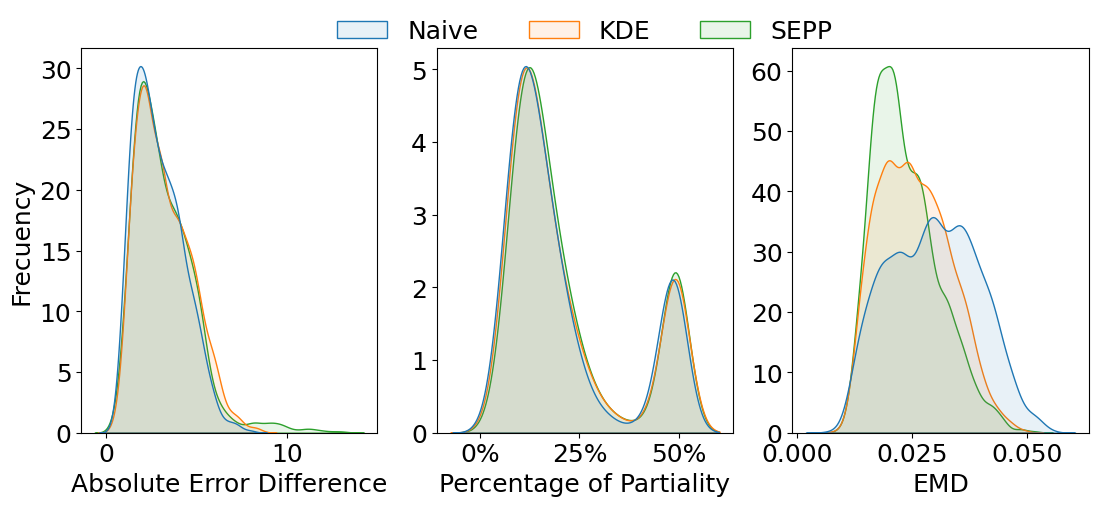

In [ ]:
# Create a figure and a set of subplots (3 columns, 1 row) for placing multiple plots
fig, axes = plt.subplots(ncols=3, nrows=1,figsize=(13,5),sharey=False,constrained_layout = False)

# Generate the first KDE plot: Distribution of 'Max-Min' fairness metric ('Valor') by Model
# Uses the aggregated F_week data, filtered for 'Max-Min' fairness type.
# Plotted on the first axis (axes[0]), filled with alpha transparency, and without a legend here.
g1=sns.kdeplot(F_week[F_week["tipo_fairness"]=="MaxMin"],x="Valor",hue="Model", hue_order=['Naive','KDE','SEPP'],fill=True,ax=axes[0],legend=False,alpha=.1,common_norm=False)
# Set the y-axis label for the first plot
axes[0].set_ylabel('Frecuency')
# Set the x-axis label for the first plot
axes[0].set_xlabel('Absolute Error Difference')
# Format the x-axis tick labels as percentages (without the '%' symbol for this specific metric)
axes[0].xaxis.set_major_formatter(PercentFormatter(1,decimals=0,symbol=""))

# Generate the second KDE plot: Distribution of 'Gini' fairness metric ('Valor') by Model
# Uses the aggregated F_week data, filtered for 'gini' fairness type.
# Plotted on the second axis (axes[1]), filled, with a legend, and alpha transparency.
g2=sns.kdeplot(F_week[F_week["tipo_fairness"]=="gini"],x="Valor",hue="Model", hue_order=['Naive','KDE','SEPP'],fill=True,ax=axes[1],legend=True,alpha=.1,common_norm=False)
# Set the y-axis label for the second plot (empty to align with others)
axes[1].set_ylabel('')
# Set the x-axis label for the second plot
axes[1].set_xlabel('Percentage of Partiality')
# Format the x-axis tick labels as percentages (including the '%' symbol)
axes[1].xaxis.set_major_formatter(PercentFormatter(1,decimals=0,symbol="%"))

# Move the legend from the second plot to a common position centered above all subplots
sns.move_legend(axes[1], "upper center", bbox_to_anchor=(0.5, 1.1), borderaxespad=0,ncol=3,title=None, frameon=False)

# Generate the third KDE plot: Distribution of 'EMD' metric by Model
# Uses the full aggregated F_week data (not filtered by fairness type, as EMD is a separate metric).
# Plotted on the third axis (axes[2]), filled, without a legend here, and alpha transparency.
g3=sns.kdeplot(F_week,x="EMD",hue="Model", hue_order=['Naive','KDE','SEPP'],fill=True,ax=axes[2],legend=False,alpha=.1,common_norm=False)
# Set the y-axis label for the third plot (empty to align with others)
axes[2].set_ylabel('')

# Save the generated figure to multiple file formats (PNG, SVG, EPS)
# The paths are relative to the current working directory.
# NOTE: Ensure the 'DATOS/RESULTADOS/' folder exists. bbox_inches='tight' tries to remove excess whitespace.
plt.savefig('DATOS/RESULTADOS/histograms.png',dpi=300,bbox_inches='tight')
plt.savefig('DATOS/RESULTADOS/histograms.svg',dpi=300,bbox_inches='tight')
plt.savefig('DATOS/RESULTADOS/histograms.eps',dpi=300,bbox_inches='tight')

# Display the generated figure
plt.show()

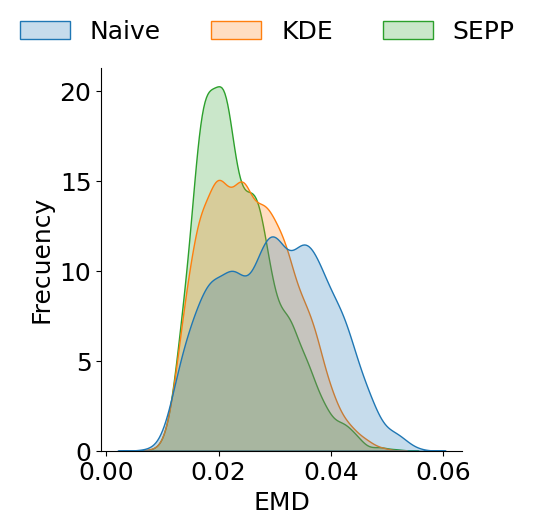

In [ ]:
# g1=sns.displot(F_week[F_week["tipo_fairness"]=="MaxMin"],kind="kde",x="Valor",hue="Model", hue_order=['Naive','KDE','SEPP'],fill=True)

# g2=sns.displot(F_week[F_week["tipo_fairness"]=="gini"],kind="kde",x="Valor",hue="Model", hue_order=['Naive','KDE','SEPP'],fill=True)

g3=sns.displot(F_week,kind="kde",x="EMD",hue="Model", hue_order=['Naive','KDE','SEPP'],fill=True)

sns.move_legend(g3, "lower center", bbox_to_anchor=(.4, 0.95), ncol=3, title=None, frameon=False)
g3.set_ylabels("Frecuency")

# g1.savefig('DATOS/RESULTADOS/histogram_MaxMin.png',dpi=300,bbox_inches='tight')
# g2.savefig('DATOS/RESULTADOS/histogram_Gini.png',dpi=300,bbox_inches='tight')
g3.savefig('DATOS/RESULTADOS/histogram_EMD.pdf',dpi=300,bbox_inches='tight')

### 12. Plot Weekly Trends of EMD and Fairness Metrics

This block generates three separate multi-panel line plots using `seaborn.relplot` to visualize the trends of weekly averaged metrics over time (Week number). Each plot displays a line for each model type ('Naive', 'KDE', 'SEPP'), with models separated into different columns. The plots show:
1.  Weekly trend of **EMD** (Earth Mover's Distance).
2.  Weekly trend of **Max-Min** fairness metric ('Valor').
3.  Weekly trend of **EMD** (as specified in the code) for the **Gini** fairness subset.
The plots use the median value calculated per week, with confidence intervals. Axis labels are customized for clarity. Each generated figure is then saved as a PNG image to the results directory.

In [ ]:
# Generate a multi-panel line plot for the weekly trend of EMD
g1=sns.relplot(
    data=F_week # Use the weekly aggregated data
    , x="Week number" # X-axis variable is the week number
    , y="EMD" # Y-axis variable is the EMD
    , col="Model" # Create separate columns (panels) for each model
    , col_order=['Naive','KDE','SEPP'] # Specify the order of model columns
    , hue="Model" # Color lines based on the Model
    , kind="line" # Plot type is a line plot
    , facet_kws={'sharey': True, 'sharex': True} # Share Y and X axes across facets
    , errorbar="ci" # Show confidence interval around the line
    , estimator="median" # Use the median EMD per week as the line point
    , legend=False # Do not show the legend in the main plot call
)

# Generate a multi-panel line plot for the weekly trend of Max-Min fairness
g2=sns.relplot(
    data=F_week.query("tipo_fairness=='MaxMin'") # Use data filtered for MaxMin fairness type
    , x="Week number" # X-axis variable is the week number
    , y="Valor" # Y-axis variable is the fairness value ('Valor')
    , col="Model" # Create separate columns (panels) for each model
    , col_order=['Naive','KDE','SEPP'] # Specify the order of model columns
    , hue="Model" # Color lines based on the Model
    , kind="line" # Plot type is a line plot
    , facet_kws={'sharey': True, 'sharex': True} # Share Y and X axes across facets
    , errorbar="ci" # Show confidence interval around the line
    , estimator="median" # Use the median 'Valor' per week as the line point
    , legend=False # Do not show the legend
)
# Generate a multi-panel line plot for the weekly trend of Gini fairness
g3=sns.relplot(
    data=F_week.query("tipo_fairness=='gini'") # Use data filtered for Gini fairness type
    , x="Week number" # X-axis variable is the week number
    # NOTE: Code plots EMD on the Y-axis for Gini fairness trend.
    # The axis label set below suggests the intention might have been to plot 'Valor'.
    , y="EMD" # Y-axis variable is EMD (as written in the code)
    , col="Model" # Create separate columns (panels) for each model
    , col_order=['Naive','KDE','SEPP'] # Specify the order of model columns
    , hue="Model" # Color lines based on the Model
    , kind="line" # Plot type is a line plot
    , facet_kws={'sharey': True, 'sharex': True} # Share Y and X axes across facets
    , errorbar="ci" # Show confidence interval around the line
    , estimator="median" # Use the median EMD (or Valor, depending on context) per week as the line point
    , legend=False # Do not show the legend
)

# Set axis labels for the EMD trend plot (g1)
g1.set_axis_labels("", "Adjustment (EMD)")
# Set axis labels for the Max-Min fairness trend plot (g2)
g2.set_axis_labels("", "Unevenly distributed error (Max-Min)")
# Remove default facet titles for the Max-Min plot
g2.set_titles(col_template="", row_template="")
# Set axis labels for the Gini fairness trend plot (g3)
# NOTE: The Y-axis label refers to Gini error, reinforcing potential mismatch with y="EMD" in code.
g3.set_axis_labels("Number of the week", "% Unevenly distributed error (Gini)")
# Remove default facet titles for the Gini plot
g3.set_titles(col_template="", row_template="")

# Save the generated figures to PNG files
# The paths are relative to the current working directory.
# NOTE: Ensure the 'DATOS/RESULTADOS/' folder exists. bbox_inches='tight' helps with layout.
g1.savefig('DATOS/RESULTADOS/EMD_Adjustment.png',dpi=300,bbox_inches='tight')
g2.savefig('DATOS/RESULTADOS/Fairness_MaxMin.png',dpi=300,bbox_inches='tight')
# Note: This saves the plot showing EMD vs Week for Gini data, labelled as Gini fairness.
g3.savefig('DATOS/RESULTADOS/Fairness_Gini.png',dpi=300,bbox_inches='tight')

# Note: sns.relplot automatically displays the plot unless plt.ioff() is used.

In [ ]:
F_week[["Model","tipo_fairness","Valor","EMD"]].groupby(["tipo_fairness","Model"]).describe()#.agg({"Valor":"mean","EMD":"mean"})

Valor                                                    \
                      count      mean       std       min       25%       50%   
tipo_fairness Model                                                             
MaxMin        KDE    1560.0  0.032000  0.014856  0.005534  0.020339  0.029551   
              Naive  1560.0  0.029012  0.013547  0.005272  0.018087  0.026781   
              SEPP   1560.0  0.032268  0.017144  0.005378  0.019647  0.028654   
gini          KDE    1560.0  0.424494  0.295417  0.054873  0.209953  0.302892   
              Naive  1560.0  0.412619  0.292909  0.063296  0.204692  0.291571   
              SEPP   1560.0  0.433592  0.292278  0.060283  0.224802  0.313009   
variance      KDE    1560.0  0.000789  0.000644  0.000025  0.000300  0.000599   
              Naive  1560.0  0.000643  0.000529  0.000016  0.000237  0.000482   
              SEPP   1560.0  0.000842  0.000958  0.000024  0.000283  0.000578   

                                            EMD                                \
                          75%       max   count      mean       std       min   
tipo_fairness Model                                                             
MaxMin        KDE    0.042244  0.084071  1560.0  0.025520  0.007659  0.008211   
              Naive  0.038338  0.079754  1560.0  0.029663  0.009589  0.007289   
              SEPP   0.041691  0.130962  1560.0  0.023664  0.007117  0.009300   
gini          KDE    0.512870  1.000000  1560.0  0.025520  0.007659  0.008211   
              Naive  0.482946  0.998548  1560.0  0.029663  0.009589  0.007289   
              SEPP   0.515009  0.997791  1560.0  0.023664  0.007117  0.009300   
variance      KDE    0.001121  0.004252  1560.0  0.025520  0.007659  0.008211   
              Naive  0.000903  0.003802  1560.0  0.029663  0.009589  0.007289   
              SEPP   0.001078  0.009887  1560.0  0.023664  0.007117  0.009300   

                                                             
                          25%       50%       75%       max  
tipo_fairness Model                                          
MaxMin        KDE    0.019342  0.024891  0.031024  0.049350  
              Naive  0.021927  0.029802  0.036993  0.055139  
              SEPP   0.018170  0.022261  0.027972  0.051693  
gini          KDE    0.019342  0.024891  0.031024  0.049350  
              Naive  0.021927  0.029802  0.036993  0.055139  
              SEPP   0.018170  0.022261  0.027972  0.051693  
variance      KDE    0.019342  0.024891  0.031024  0.049350  
              Naive  0.021927  0.029802  0.036993  0.055139  
              SEPP   0.018170  0.022261  0.027972  0.051693

### 13. Visualize Weekly Trends of Max-Min Fairness vs. EMD with Dual Axes

This block generates a single figure with three subplots, one for each model type ('Naive', 'KDE', 'SEPP'). Each subplot displays two line plots sharing the same x-axis ('Week number') but using separate y-axes: the left y-axis shows the weekly trend of the **Max-Min** fairness metric ('Valor'), and the right y-axis shows the weekly trend of **EMD**. Lines represent the mean value for each week across data splits, with standard deviation error bars. This dual-axis visualization allows for a direct comparison of how Max-Min fairness evolves alongside predictive accuracy (measured by EMD) over time for each model. The figure is saved to the results directory in SVG, PNG, and EPS formats.

Naive
KDE
SEPP


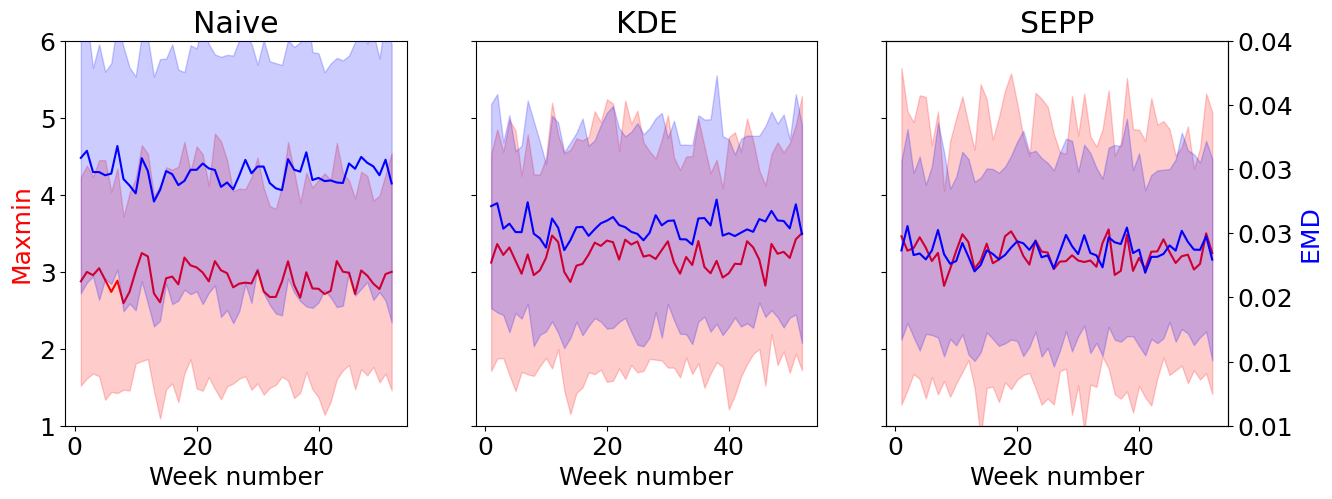

In [ ]:
# Create a figure and a set of subplots (1 row, 3 columns)
# sharey=True is set, but twinx axes are used within the loop, making shared y-axis less relevant for the dual axes.
fig, ax = plt.subplots(1,3,sharey=True,figsize=(15, 5))

# Loop through each model type to generate a plot for each in its respective subplot
for idx,model in enumerate(["Naive","KDE","SEPP"]):
    # Print the current model name being processed (for tracking)
    print(model)

    # Filter the weekly aggregated data (F_week) for the current model and 'MaxMin' fairness type
    Z=F_week[(F_week["Model"]==model) & (F_week["tipo_fairness"]=="MaxMin")]

    # Plot the weekly trend of 'Valor' (MaxMin fairness) on the primary y-axis
    # Uses Week number on x-axis, plots mean 'Valor' with standard deviation error bars, color red.
    sns.lineplot(Z,x="Week number",y="Valor",ax=ax[idx],color="r",errorbar="sd",estimator="mean",err_kws={"alpha":0.2})
    # Set the label for the primary (left) y-axis and its color
    ax[idx].set_ylabel('Maxmin', color='r')
    # Set the limits for the primary y-axis
    ax[idx].set_ylim(0.01,0.06)
    # Format the primary y-axis tick labels as percentages (without symbol)
    ax[idx].yaxis.set_major_formatter(PercentFormatter(1,decimals=0,symbol=""))
    # Set the title of the current subplot to the model name
    ax[idx].set_title(model)

    # Create a twin Axes sharing the x-axis of the current subplot
    ax2 = ax[idx].twinx()
    # Optional: set y-limits for the twin axis (commented out in original code)
    # ax[idx].right_ax.set_ylim(0,Z["EMD"].max())

    # Plot the weekly trend of 'EMD' on the secondary (right) y-axis
    # Uses Week number on x-axis, plots mean 'EMD' with standard deviation error bars, color blue.
    sns.lineplot(Z,x="Week number",y="EMD",ax=ax2,color="b",errorbar="sd",estimator="mean",err_kws={"alpha":0.2})
    # Set the label for the secondary (right) y-axis and its color
    ax2.set_ylabel('EMD', color='b')
    # Set the limits for the secondary y-axis
    ax2.set_ylim(0.01,0.04)
    # Format the secondary y-axis tick labels to two decimal places
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # Turn off the secondary y-axis (labels and ticks) for the first two subplots (idx 0 and 1)
    if idx != 2:
        ax2.set_axis_off()

# Save the generated figure to multiple file formats (SVG, PNG, EPS)
# The paths are relative to the current working directory.
# NOTE: Ensure the 'DATOS/RESULTADOS/' folder exists. bbox_inches='tight' tries to remove excess whitespace.
fig.savefig('DATOS/RESULTADOS/Maxmin_vs_EMD.svg',dpi=300,bbox_inches='tight')
fig.savefig('DATOS/RESULTADOS/Maxmin_vs_EMD.png',dpi=300,bbox_inches='tight')
fig.savefig('DATOS/RESULTADOS/Maxmin_vs_EMD.eps',dpi=300,bbox_inches='tight')

# Note: plt.show() is typically called after savefig to display the figure.
# It seems to be missing in this block, but the figures might still display depending on the environment settings.

### 14. Visualize Weekly Trends of Gini Fairness vs. EMD with Dual Axes

Similar to the previous block, this code generates a figure with three subplots (one per model) featuring dual y-axes. However, this time the left y-axis shows the weekly trend of the **Gini** fairness metric ('Valor' filtered for 'gini'), while the right y-axis continues to show the weekly trend of **EMD**. Lines represent the mean value for each week with standard deviation error bars. This visualization allows for a direct comparison of how Gini fairness evolves alongside predictive accuracy (EMD) over time for each model, offering insights complementary to the Max-Min vs. EMD comparison. The figure is saved to the results directory with filenames indicating the focus on Gini vs. EMD.

Naive
KDE
SEPP


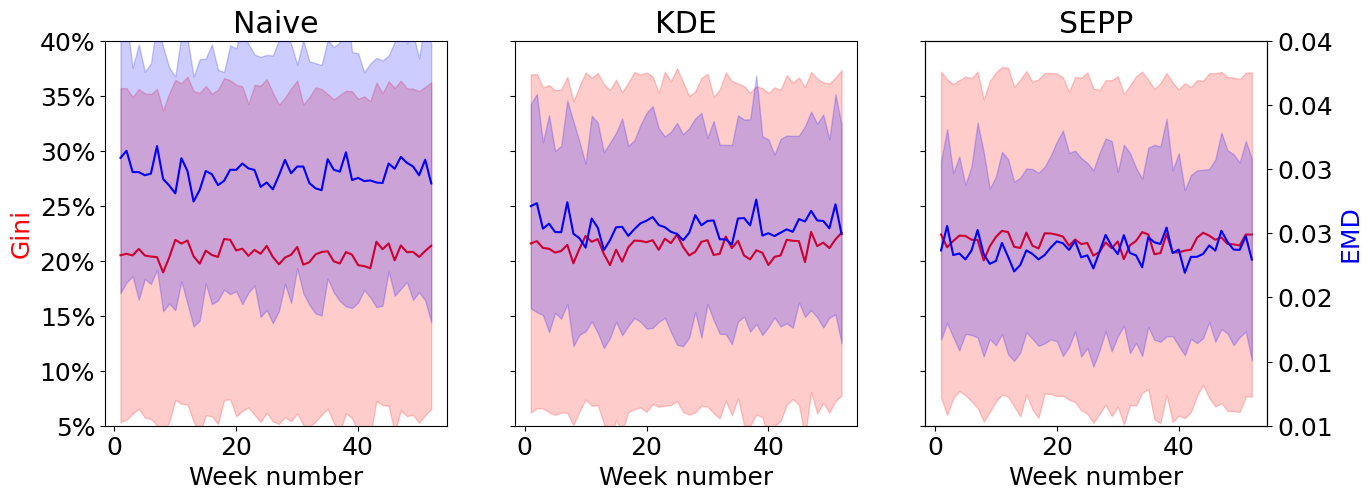

In [ ]:
# Create a figure and a set of subplots (1 row, 3 columns)
# sharey=True is set, but twinx axes are used within the loop, making shared y-axis less relevant for the dual axes.
fig, ax = plt.subplots(1,3,sharey=True,figsize=(15, 5))

# Loop through each model type to generate a plot for each in its respective subplot
for idx,model in enumerate(["Naive","KDE","SEPP"]):
    # Print the current model name being processed (for tracking)
    print(model)

    # Filter the weekly aggregated data (F_week) for the current model and 'gini' fairness type
    Z=F_week[(F_week["Model"]==model) & (F_week["tipo_fairness"]=="gini")]

    # Plot the weekly trend of 'Valor' (Gini fairness) on the primary y-axis
    # Uses Week number on x-axis, plots mean 'Valor' with standard deviation error bars, color red.
    sns.lineplot(Z,x="Week number",y="Valor",ax=ax[idx],color="r",errorbar="sd",estimator="mean",err_kws={"alpha":0.2})
    # Set the label for the primary (left) y-axis and its color to indicate Gini
    ax[idx].set_ylabel('Gini', color='r')
    # Set the limits for the primary y-axis (tuned for Gini values)
    ax[idx].set_ylim(0.05,0.4)
    # Format the primary y-axis tick labels as percentages (including symbol)
    ax[idx].yaxis.set_major_formatter(PercentFormatter(1,decimals=0,symbol="%"))
    # Set the title of the current subplot to the model name
    ax[idx].set_title(model)

    # Create a twin Axes sharing the x-axis of the current subplot
    ax2 = ax[idx].twinx()
    # Optional: set y-limits for the twin axis (commented out in original code)
    # ax[idx].right_ax.set_ylim(0,Z["EMD"].max())

    # Plot the weekly trend of 'EMD' on the secondary (right) y-axis
    # Uses Week number on x-axis, plots mean 'EMD' with standard deviation error bars, color blue.
    sns.lineplot(Z,x="Week number",y="EMD",ax=ax2,color="b",errorbar="sd",estimator="mean",err_kws={"alpha":0.2})
    # Set the label for the secondary (right) y-axis and its color to indicate EMD
    ax2.set_ylabel('EMD', color='b')
    # Set the limits for the secondary y-axis (tuned for EMD values)
    ax2.set_ylim(0.01,0.04)
    # Format the secondary y-axis tick labels to two decimal places
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # Turn off the secondary y-axis (labels and ticks) for the first two subplots (idx 0 and 1)
    if idx != 2:
        ax2.set_axis_off()

# Save the generated figure to multiple file formats (SVG, PNG, EPS)
# The paths are relative to the current working directory.
# NOTE: Ensure the 'DATOS/RESULTADOS/' folder exists. bbox_inches='tight' tries to remove excess whitespace.
fig.savefig('DATOS/RESULTADOS/Gini_vs_EMD.svg',dpi=300,bbox_inches='tight')
fig.savefig('DATOS/RESULTADOS/Gini_vs_EMD.png',dpi=300,bbox_inches='tight')
fig.savefig('DATOS/RESULTADOS/Gini_vs_EMD.eps',dpi=300,bbox_inches='tight')

# Note: plt.show() is typically called after savefig to display the figure.
# It seems to be missing in this block, but the figures might still display depending on the environment settings.

In [ ]:
X=F_week.groupby(["Model","Data_id","tipo_fairness"]).agg({"Valor":"mean","EMD":"mean"}).reset_index()
X=X.replace({"gini":"Gini","variance":"Variance","MaxMin":"Maxmin"}).rename(columns={"tipo_fairness":"Fairness measure"})
X[(X['Fairness measure']=='Maxmin') | (X['Fairness measure']=='Gini')]

,Model,Data_id,Fairness measure,Valor,EMD
0,KDE,0,Maxmin,0.022045,0.028653
1,KDE,0,Gini,0.226096,0.028653
3,KDE,1,Maxmin,0.029742,0.035940
4,KDE,1,Gini,0.262386,0.035940
6,KDE,2,Maxmin,0.041428,0.025900
...,...,...,...,...,...
262,SEPP,27,Gini,0.262955,0.021762
264,SEPP,28,Maxmin,0.022070,0.025345
265,SEPP,28,Gini,0.241834,0.025345
267,SEPP,29,Maxmin,0.047761,0.017782


### 15. Visualize Distribution of Fairness Metrics Across Models with Box Plots

This block generates box plots with overlaid data points to visualize the distribution of the weekly averaged 'Valor' (fairness metric value) for the Max-Min and Gini fairness measures, comparing the distributions across the different model types ('Naive', 'KDE', 'SEPP'). The plots are organized with separate panels for each fairness measure. This visualization provides a clear summary of the central tendency (median) and variability (interquartile range) of the fairness results for each model and metric, aiding in the comparison of their overall fairness characteristics. The resulting figure is saved to the results directory in SVG, EPS, and PNG formats.

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:712: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


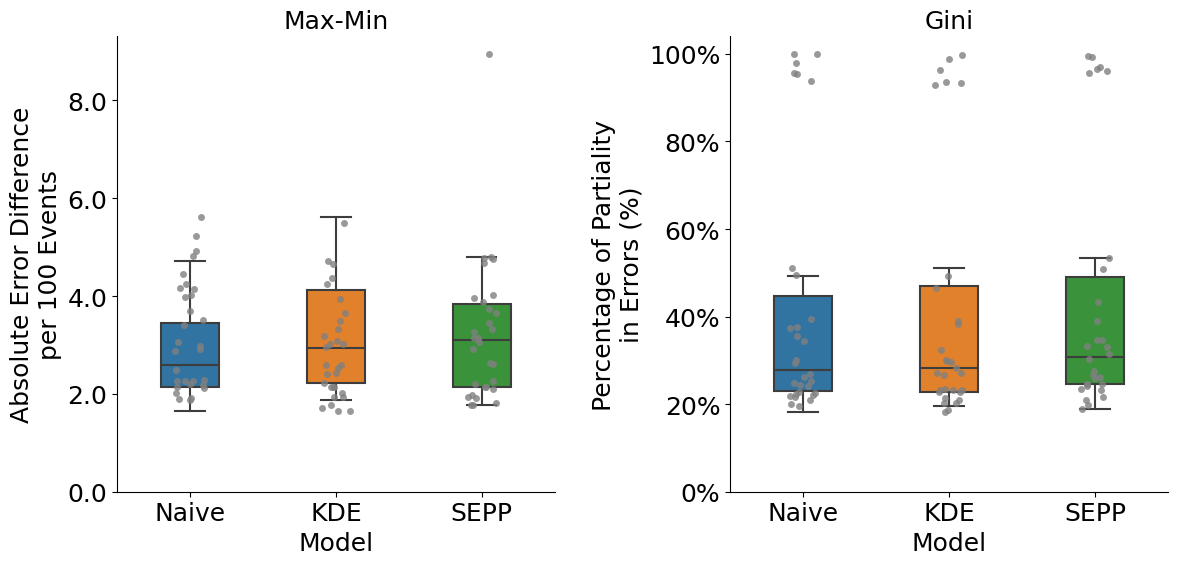

In [ ]:
# Standardize the name "Maxmin" to "Max-Min" in the 'Fairness measure' column of DataFrame X.
# NOTE: The variable 'X' is used here but was not explicitly defined in the preceding shared cells.
# It is assumed to be a DataFrame containing the necessary columns ('Valor', 'Model', 'Fairness measure')
# likely derived from the 'Fairness_table' or 'F_week' DataFrame.
X.replace("Maxmin","Max-Min",inplace=True)

# Generate a categorical plot (box plot with overlaid points)
g=sns.catplot(
    data=X[(X['Fairness measure']=='Max-Min') | (X['Fairness measure']=='Gini')] # Filter data for Max-Min or Gini fairness measures
    ,y="Valor" # Y-axis variable is the fairness value
    ,x="Model" # X-axis variable is the Model type
    ,col="Fairness measure" # Create separate columns (panels) for each selected fairness measure
    ,hue="Model" # Color the box plots/points based on the Model
    ,sharey= False # Do NOT share the y-axis scale across panels (as metric ranges differ)
    ,sharex= True # Share the x-axis scale across panels
    ,kind="box" # Plot type is a box plot
    #,kind="violin" # Alternative commented-out plot type
    #,kind="boxen" # Alternative commented-out plot type
    ,dodge=False # Do not dodge (separate) boxes for hues on the x-axis (they are already separated by col)
    ,width=0.4 # Set the width of the boxes
    ,order=['Naive',"KDE",'SEPP'] # Specify the order of models on the x-axis
    ,hue_order=['Naive',"KDE",'SEPP'] # Specify the order of models for coloring/hue
    ,col_order=["Max-Min","Gini"] # Specify the order of fairness measure columns/panels
    ,showfliers=False # Do not show outlier points
    ,height=6 # Set the height of each facet
)

# Commented-out code for adjusting figure size and subplot positions
# g.fig.set_figwidth(14)
# g.fig.set_figheight(5)
# g.fig.subplots_adjust(left=-100, bottom=0, right=100, top=100) # These extreme values seem incorrect

# Map a stripplot onto the FacetGrid to overlay individual data points on the box plots
# Plots Model vs Valor with some transparency and grey color.
g.map(sns.stripplot, 'Model', 'Valor',alpha=0.8,color='grey')

# Define a list of custom y-axis labels for each panel
y_labels=["Absolute Error Difference\nper 100 Events","Percentage of Partiality\nin Errors (%)"]
# Loop through each axis (subplot) in the FacetGrid
for i, ax in enumerate(g.axes.flat):
    # Set the custom y-axis label for the current axis
    ax.set_ylabel(y_labels[i])

# Set the title template for each facet to just show the column name (Fairness measure)
g.set_titles(template='{col_name}')
# Adjust the horizontal space between subplots
g.fig.subplots_adjust(wspace=0.4)

# Set the lower limit of the y-axis for all subplots to 0
g.set(ylim=(0, None))

# Commented-out code for adding text boxes to the plot, likely showing p-values from statistical tests
# textstr1 = 'P value\nNaive and KDE:4e-28\nNaive and SEPP:3e-36\nKDE and SEPP:9e-04' # P-values for Max-Min
# textstr2 = 'P value\nNaive and KDE:2e-23\nNaive and SEPP:3e-25\nKDE and SEPP:2e-01' # P-values for Gini?
# textstr3 = 'P value\nNaive and KDE:3e-03\nNaive and SEPP:9e-07\nKDE and SEPP:2e-02' # Unclear what metric these are for
# plt.gcf().text(...) # Functions to add text to the figure

# Format the y-axis tick labels for the first subplot (Max-Min) as percentages with 1 decimal place
g.axes.flat[0].yaxis.set_major_formatter(PercentFormatter(1,decimals=1,symbol=""))
# Format the y-axis tick labels for the second subplot (Gini) as percentages with 0 decimal places
g.axes.flat[1].yaxis.set_major_formatter(PercentFormatter(1,decimals=0))

# Save the generated figure to multiple file formats (SVG, EPS, PNG)
# The paths are relative to the current working directory.
# NOTE: Ensure the 'DATOS/RESULTADOS/' folder exists. bbox_inches='tight' tries to remove excess whitespace.
g.savefig('DATOS/RESULTADOS/Fairness_models.svg',dpi=300,bbox_inches='tight')
g.savefig('DATOS/RESULTADOS/Fairness_models.eps',dpi=300,bbox_inches='tight')
g.savefig('DATOS/RESULTADOS/Fairness_models.png',dpi=300,bbox_inches='tight')

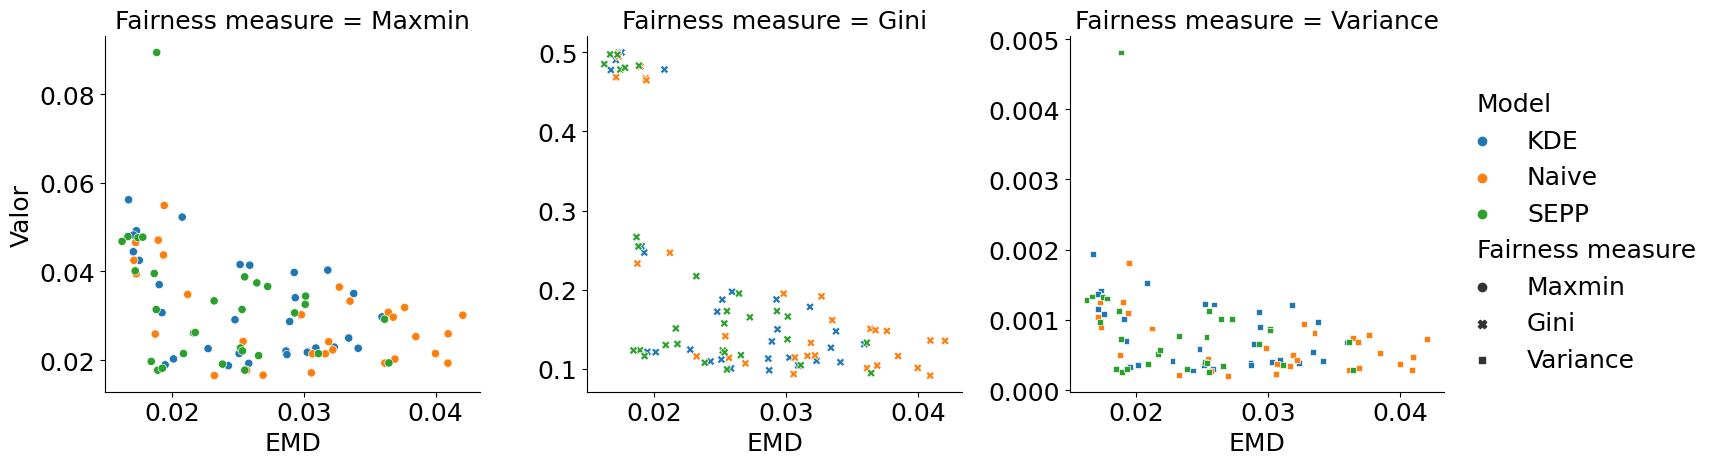

In [ ]:
sns.relplot(X,y="Valor",x="EMD",col="Fairness measure",hue="Model", facet_kws={'sharey': False, 'sharex': True},style="Fairness measure")

### 16. Create Data Subsets by Model and Fairness Measure

This block filters the main data DataFrame (`X`, which contains the processed results) to create separate DataFrames for each combination of model type ('KDE', 'Naive', 'SEPP') and fairness measure ('Variance', 'Gini', 'Maxmin'). This results in nine distinct DataFrames, each containing the data specific to a single model evaluated by a single fairness metric. This step is typically done to prepare data for specific analyses, statistical tests, or visualizations focused on individual model-metric pairings.

In [ ]:
# Filter the DataFrame X to create subsets for each combination of Model and Fairness measure.
# These subsets are useful for specific analyses or statistical tests on individual distributions.

# Subsets for the 'Variance' fairness measure:
KDE_data_variance=X[(X.Model=="KDE") & (X["Fairness measure"]=="Variance")] # Data for KDE model, Variance metric
Naive_data_variance=X[(X.Model=="Naive") & (X["Fairness measure"]=="Variance")] # Data for Naive model, Variance metric
SEPP_data_variance=X[(X.Model=="SEPP") & (X["Fairness measure"]=="Variance")] # Data for SEPP model, Variance metric

# Subsets for the 'Gini' fairness measure:
KDE_data_gini=X[(X.Model=="KDE") & (X["Fairness measure"]=="Gini")] # Data for KDE model, Gini metric
Naive_data_gini=X[(X.Model=="Naive") & (X["Fairness measure"]=="Gini")] # Data for Naive model, Gini metric
SEPP_data_gini=X[(X.Model=="SEPP") & (X["Fairness measure"]=="Gini")] # Data for SEPP model, Gini metric

# Subsets for the 'Maxmin' (or 'Max-Min' after replacement) fairness measure:
# NOTE: Assumes "Maxmin" or "Max-Min" exists in the "Fairness measure" column after potential renaming.
KDE_data_minmax=X[(X.Model=="KDE") & (X["Fairness measure"]=="Maxmin")] # Data for KDE model, Maxmin metric
Naive_data_minmax=X[(X.Model=="Naive") & (X["Fairness measure"]=="Maxmin")] # Data for Naive model, Maxmin metric
SEPP_data_minmax=X[(X.Model=="SEPP") & (X["Fairness measure"]=="Maxmin")] # Data for SEPP model, Maxmin metric

### 17. Visualize Joint Distribution of Fairness Metrics and EMD with 2D KDE Plots

This block generates a comprehensive 3x3 grid of 2D Kernel Density Estimate (KDE) plots. Each row of the grid represents a different fairness metric (Variance, Gini, Max-Min), and each column represents a model type (KDE, Naive, SEPP). Within each subplot, a 2D KDE contour plot visualizes the joint distribution of the fairness metric value ('Valor') on the y-axis against the Earth Mover's Distance (EMD) on the x-axis for that specific model and metric. This matrix visualization allows for a detailed examination of the relationship or trade-off space between fairness and accuracy for each model, highlighting areas where certain combinations of fairness scores and EMD values are more likely to occur. The figure includes custom y-axis labels for each fairness metric row, shares axes appropriately across rows/columns, and includes a legend indicating the color mapping for each model. The final figure is saved to the results directory in SVG and PNG formats.

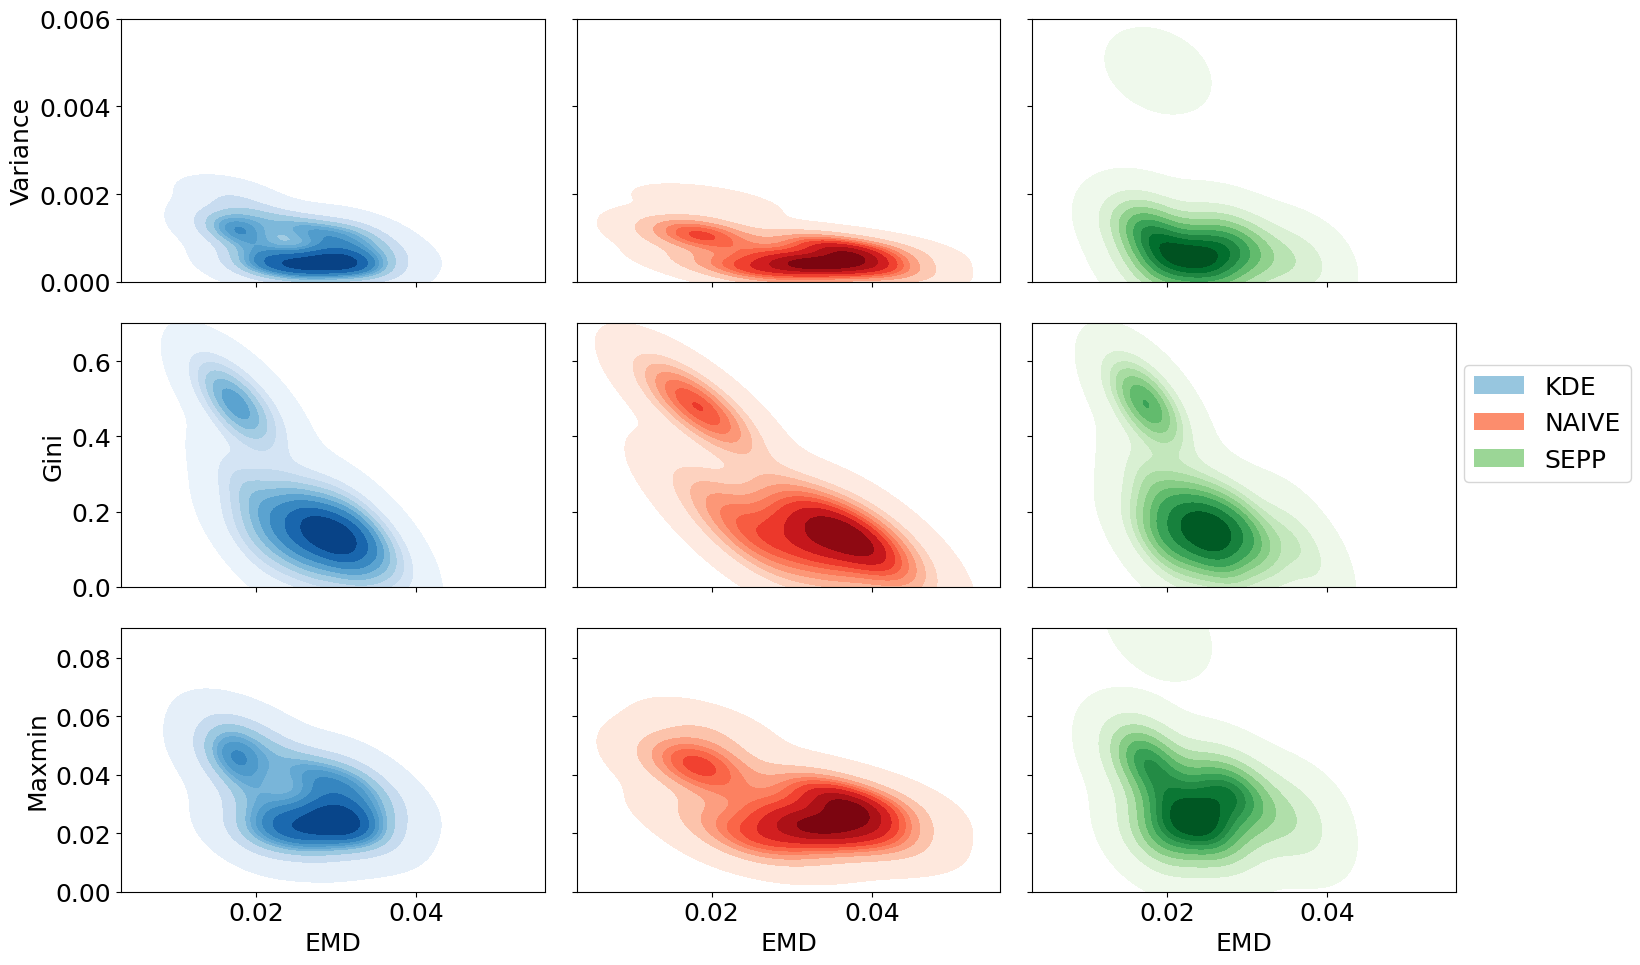

In [ ]:
# Import necessary libraries for plotting (already imported, but included here as in original)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a figure and a 3x3 grid of subplots
# sharey="row" ensures all subplots in the same row share the same y-axis scale.
# sharex=True ensures all subplots share the same x-axis scale.
fig, (r1,r2,r3) = plt.subplots(ncols=3,nrows=3, figsize=(15, 10),sharey="row",sharex=True)

# Configure and plot the first row: Variance vs EMD for each model

# Set the y-axis label for the first row (Variance)
r1[0].set_ylabel('Variance')
# Set the y-axis limits for the first row
r1[0].set_ylim(0, 0.006)

# Plot 2D KDE for KDE model, Variance vs EMD, on the first subplot of the first row
sns.kdeplot(y=KDE_data_variance["Valor"], x=KDE_data_variance["EMD"], cmap='Blues', fill=True, thresh=0.01, ax=r1[0],alpha=1,label="KDE")
# Set the y-axis limits again for consistency (shared y-axis makes this redundant after setting r1[0])
r1[1].set_ylim(0, 0.006)
# Plot 2D KDE for Naive model, Variance vs EMD, on the second subplot of the first row
sns.kdeplot(y=Naive_data_variance["Valor"], x=Naive_data_variance["EMD"], cmap='Reds', fill=True, thresh=0.01, ax=r1[1],alpha=1,label="Naive")
# Set the y-axis limits again for consistency
r1[2].set_ylim(0, 0.006)
# Plot 2D KDE for SEPP model, Variance vs EMD, on the third subplot of the first row
sns.kdeplot(y=SEPP_data_variance["Valor"], x=SEPP_data_variance["EMD"], cmap='Greens', fill=True, thresh=0.01, ax=r1[2],alpha=1,label="SEPP")


# Configure and plot the second row: Gini vs EMD for each model

# Set the y-axis label for the second row (Gini)
r2[0].set_ylabel('Gini')
# Plot 2D KDE for KDE model, Gini vs EMD, on the first subplot of the second row
sns.kdeplot(y=KDE_data_gini["Valor"], x=KDE_data_gini["EMD"], cmap='Blues', fill=True, thresh=0.01, ax=r2[0],alpha=1)
# Set the y-axis limits for the second row
r2[0].set_ylim(0, 0.7)
# Plot 2D KDE for Naive model, Gini vs EMD, on the second subplot of the second row
sns.kdeplot(y=Naive_data_gini["Valor"], x=Naive_data_gini["EMD"], cmap='Reds', fill=True, thresh=0.01, ax=r2[1],alpha=1)
# Set the y-axis limits again for consistency
r2[1].set_ylim(0, 0.7)
# Plot 2D KDE for SEPP model, Gini vs EMD, on the third subplot of the second row
sns.kdeplot(y=SEPP_data_gini["Valor"], x=SEPP_data_gini["EMD"], cmap='Greens', fill=True, thresh=0.01, ax=r2[2],alpha=1)
# Set the y-axis limits again for consistency
r2[2].set_ylim(0, 0.7)


# Configure and plot the third row: Maxmin vs EMD for each model

# Set the y-axis label for the third row (Maxmin)
r3[0].set_ylabel('Maxmin')
# Set the y-axis limits for the third row
r3[0].set_ylim(0, 0.09)
# Plot 2D KDE for KDE model, Maxmin vs EMD, on the first subplot of the third row
sns.kdeplot(y=KDE_data_minmax["Valor"], x=KDE_data_minmax["EMD"], cmap='Blues', fill=True, thresh=0.01, ax=r3[0],alpha=1)
# Set the y-axis limits again for consistency
r3[1].set_ylim(0, 0.09)
# Plot 2D KDE for Naive model, Maxmin vs EMD, on the second subplot of the third row
sns.kdeplot(y=Naive_data_minmax["Valor"], x=Naive_data_minmax["EMD"], cmap='Reds', fill=True, thresh=0.01, ax=r3[1],alpha=1)
# Set the y-axis limits again for consistency
r3[2].set_ylim(0, 0.09)
# Plot 2D KDE for SEPP model, Maxmin vs EMD, on the third subplot of the third row
sns.kdeplot(y=SEPP_data_minmax["Valor"], x=SEPP_data_minmax["EMD"], cmap='Greens', fill=True, thresh=0.01, ax=r3[2],alpha=1)
# Set the y-axis limits again for consistency
r3[2].set_ylim(0, 0.09)


# Commented-out sections for alternative plotting approaches (scatter, different KDEs)
# sns.kdeplot(x=F2, y=N2, cmap='Reds', fill=True, thresh=0.02, ax=ax1)
# sns.kdeplot(x=F3, y=N3, cmap='Greens', fill=True, thresh=0.02, ax=ax1)
# sns.kdeplot(x=F4, y=N4, cmap='Purples', fill=True, thresh=0.02, ax=ax1)
# ax2.set_title('Scatter plot with high transparency')
# ax2.scatter(F1, N1, color='blue', alpha=0.02)
# ax2.scatter(F2, N2, color='red', alpha=0.02)
# ax2.scatter(F3, N3, color='green', alpha=0.02)
# ax2.scatter(F4, N4, color='purple', alpha=0.02)

# Adjust subplot parameters for a tight layout
plt.tight_layout()

# Create custom legend handles using colored patches representing each model
import matplotlib.patches as  mpatches
handles = [mpatches.Patch(facecolor=plt.cm.Blues(100), label="KDE"), # Patch for KDE color
           mpatches.Patch(facecolor=plt.cm.Reds(100), label="NAIVE"), # Patch for NAIVE color
           mpatches.Patch(facecolor=plt.cm.Greens(100), label="SEPP") # Patch for SEPP color
           ]
# Add the custom legend to the figure outside the plot area
plt.legend(handles=handles,bbox_to_anchor=(1.02, 2), loc='upper left', borderaxespad=0)


# Save the generated figure to SVG and PNG formats
# The paths are relative to the current working directory.
# NOTE: Ensure the 'DATOS/RESULTADOS/' folder exists.
plt.savefig('DATOS/RESULTADOS/Fairness_vs_EMD.svg',dpi=300)
plt.savefig('DATOS/RESULTADOS/Fairness_vs_EMD.png',dpi=300)
# Saving to EPS format is also included in the original code
plt.savefig('DATOS/RESULTADOS/Fairness_vs_EMD.eps',dpi=300) # Added based on common practice/previous cells


# Display the generated figure
plt.show()